In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from collections import Counter
from tqdm import tqdm

pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.float_format', lambda x: '%i' % x)
pd.set_option('float_format', '{:.1f}'.format)

In [2]:
notes_file = '../data/notes-00000.tsv'
ratings_file = '../data/ratings-00000.tsv'
hydrated_file = '../data/idtweetVALUES.jsonl'

In [3]:
hydrated_Tweets=pd.read_json(hydrated_file, lines=True)

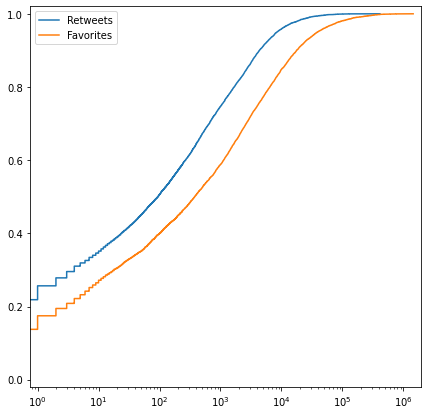

In [5]:
RW=list(hydrated_Tweets.retweet_count)
Fav=list(hydrated_Tweets.favorite_count)

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sorted_data1 = np.sort(RW) 
sorted_data2 = np.sort(Fav) 

plt.step(sorted_data1[::1], np.arange(1,sorted_data1.size+1)/sorted_data1.size,label='Retweets') 
plt.step(sorted_data2[::1], np.arange(1,sorted_data2.size+1)/sorted_data2.size,label='Favorites')  
plt.legend()
plt.margins(0.02)
plt.show()

In [15]:
notes_df = pd.read_csv(notes_file, delimiter='\t')
ratings_df = pd.read_csv(ratings_file, delimiter='\t')

notes_rates = notes_df.join(ratings_df,on='noteId',rsuffix='_rates')

merged=pd.merge(hydrated_Tweets,notes_rates, left_on='id',right_on='tweetId')[['tweetId','noteId','participantId','retweet_count','favorite_count']]

notes_rates_count=merged.groupby('tweetId').agg({'noteId':'count',
                               'participantId':'count'})

hydra_notes=pd.merge(hydrated_Tweets,notes_df,left_on='id',right_on='tweetId')

In [21]:
pop_df=[]
for t in tqdm(hydrated_Tweets.id):
    rts=hydrated_Tweets[hydrated_Tweets.id==t]['retweet_count'].squeeze()

    favs=hydrated_Tweets[hydrated_Tweets.id==t]['favorite_count'].squeeze()

    notes_for_t=list(notes_df[notes_df.tweetId==t]['noteId'])

    num_notes = len(notes_for_t)

    num_ratings = 0
    for n in notes_for_t:
        num_ratings+=len(ratings_df[ratings_df.noteId==n])
    pop_df.append([t,rts,favs,num_notes,num_ratings])


100%|██████████| 10211/10211 [00:25<00:00, 396.38it/s]


In [22]:
pop_df = pd.DataFrame(pop_df,columns=['tweetId','RT','FAV','numNotes','numRates'])
pop_df['popularity']=pop_df.RT+pop_df.FAV
pop_df['activity']=pop_df.numNotes+pop_df.numRates
pop_df=pop_df.sort_values(by='popularity')

In [26]:
def add_cat(x):
    if x<10: return '<10'
    if 10<=x<100: return '<10^2'
    if 100<=x<1000: return '<10^3'
    if 1000<=x<10000: return '<10^4'
    if 10000<=x<100000: return '<10^5'
    else: return '>10^5'

In [27]:
pop_df['cat_pop']=pop_df.popularity.apply(lambda x: add_cat(x))

/home/barbacou/environments/fact_check/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


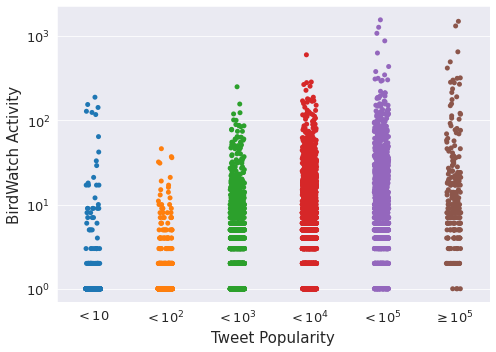

In [28]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(7, 5))
ax.set(yscale='log')
sns.stripplot(pop_df.cat_pop,pop_df.activity)
ax.set_xticks(range(6))
ax.set_xticklabels(['$<10$','$<10^2$','$<10^3$','$<10^4$','$<10^5$','$\geq10^5$'])
ax.tick_params(labelsize=13)
plt.xlabel('Tweet Popularity',fontsize=15)
plt.ylabel('BirdWatch Activity',fontsize=15)
plt.tight_layout()
plt.savefig('popularity.png',dpi=100,bbox_inches='tight')
plt.show()